# Identification of Deepfaked Images (and Videos?)
## By Li Run & Rongyi

This project aims to train an AI model to be able to identify deepfaked images from real ones with an accuracy of >=XX%.

## Data Collection

We utilized two datasets of images for training our model:
1. https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
2. https://www.kaggle.com/datasets/dagnelies/deepfake-faces

The first dataset contains approximately 70,000 training images, 5400 test images and 20,000 validation images of faces for both Real and Fake images each.

The second dataset contains approximately 95,600 images of faces. Labelling of the images as real or fake can be found under `metadata.csv`.

## Data Preprocessing

Let us first inspect the contents of `deepfake_faces`.

In [1]:
# Uncomment line below to install tensorflow with cuda 
# !pip install tensorflow[and-cuda] --target=/kaggle/working
#cuda-files

In [2]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
from sklearn.utils.class_weight import compute_class_weight
import os, os.path, shutil
from tqdm import tqdm
import cv2
import keras

In [3]:
df = pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')
df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [4]:
df[df.videoname == 'aaagqkcdis.mp4']

,videoname,original_width,original_height,label,original
18722,aaagqkcdis.mp4,90,89,FAKE,eklsrnkwog.mp4


We took the name of the first image `aaaqgkcdis.jpg` and looked it up in`metadata.csv`, confirming that the image names corresponded to entries within the csv file allowing us to label the images ourselves.

In [5]:
df['label'].value_counts()

label
FAKE    79341
REAL    16293
Name: count, dtype: int64

From here we can see that the Fake:Real ratio in `deepfake_faces` is about 5:1. We need to handle this class imbalance in our data, which we will do by just taking a sample of 16,000 images from each Fake and Real instead. We also needs to categorise the images since they have not been labelled in the same format as in `deepfake-and-real-images`.


In [5]:
# NOTE: Run if output working folder is still empty

folder_path = '/kaggle/input/deepfake-faces/faces_224/'

os.makedirs('/kaggle/working/deepfake-faces/Fake', exist_ok=True)
os.makedirs('/kaggle/working/deepfake-faces/Real', exist_ok=True)   

realcount = 0
fakecount = 0
for index, row in tqdm(df.iterrows()):
    img_name = row['videoname'].split('.')[0] + '.jpg'
    old_path = folder_path + img_name
    if row['label'] == 'REAL':
        if realcount < 16000:
            new_path = os.path.join('/kaggle/working/deepfake-faces/Real', img_name)
            realcount += 1
        else:
            continue

    else:
        if fakecount < 16000:
            new_path = os.path.join('/kaggle/working/deepfake-faces/Fake', img_name)
            fakecount += 1
        else:
            continue
    
    shutil.copy(old_path, new_path)

    
print("Categorisation complete")
        

95634it [04:56, 322.52it/s] 

Categorisation complete


Let us test if our categorisation worked.

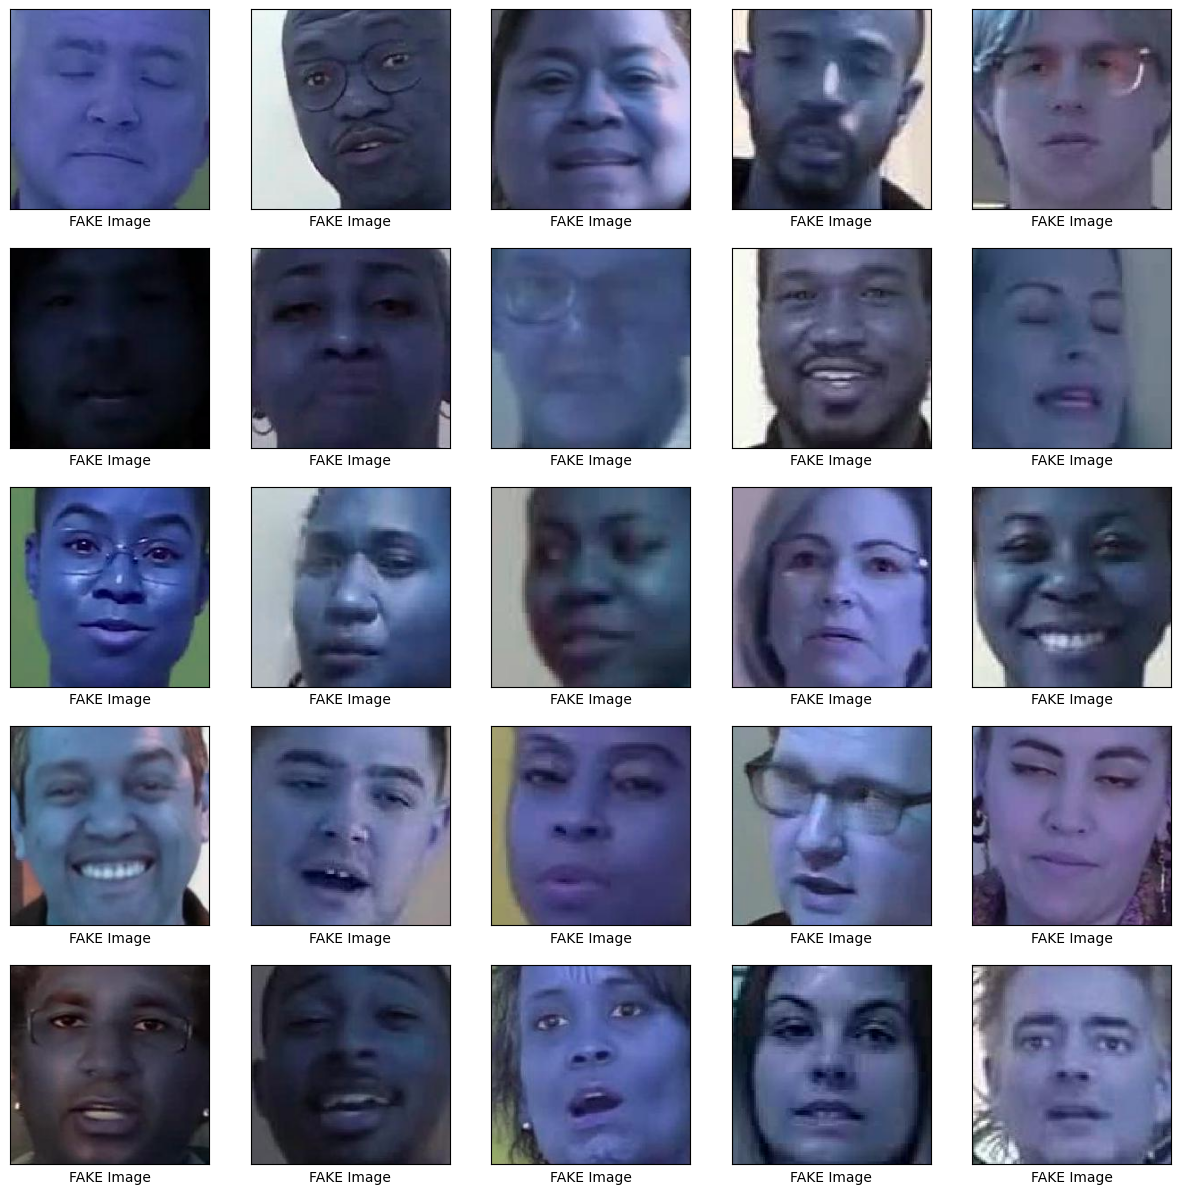

In [6]:
plt.figure(figsize=(15,15))
file_names = os.listdir('/kaggle/working/deepfake-faces/Fake/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread('/kaggle/working/deepfake-faces/Fake/'+ file_names[idx]))
    # Redundant but i want to test if any real images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

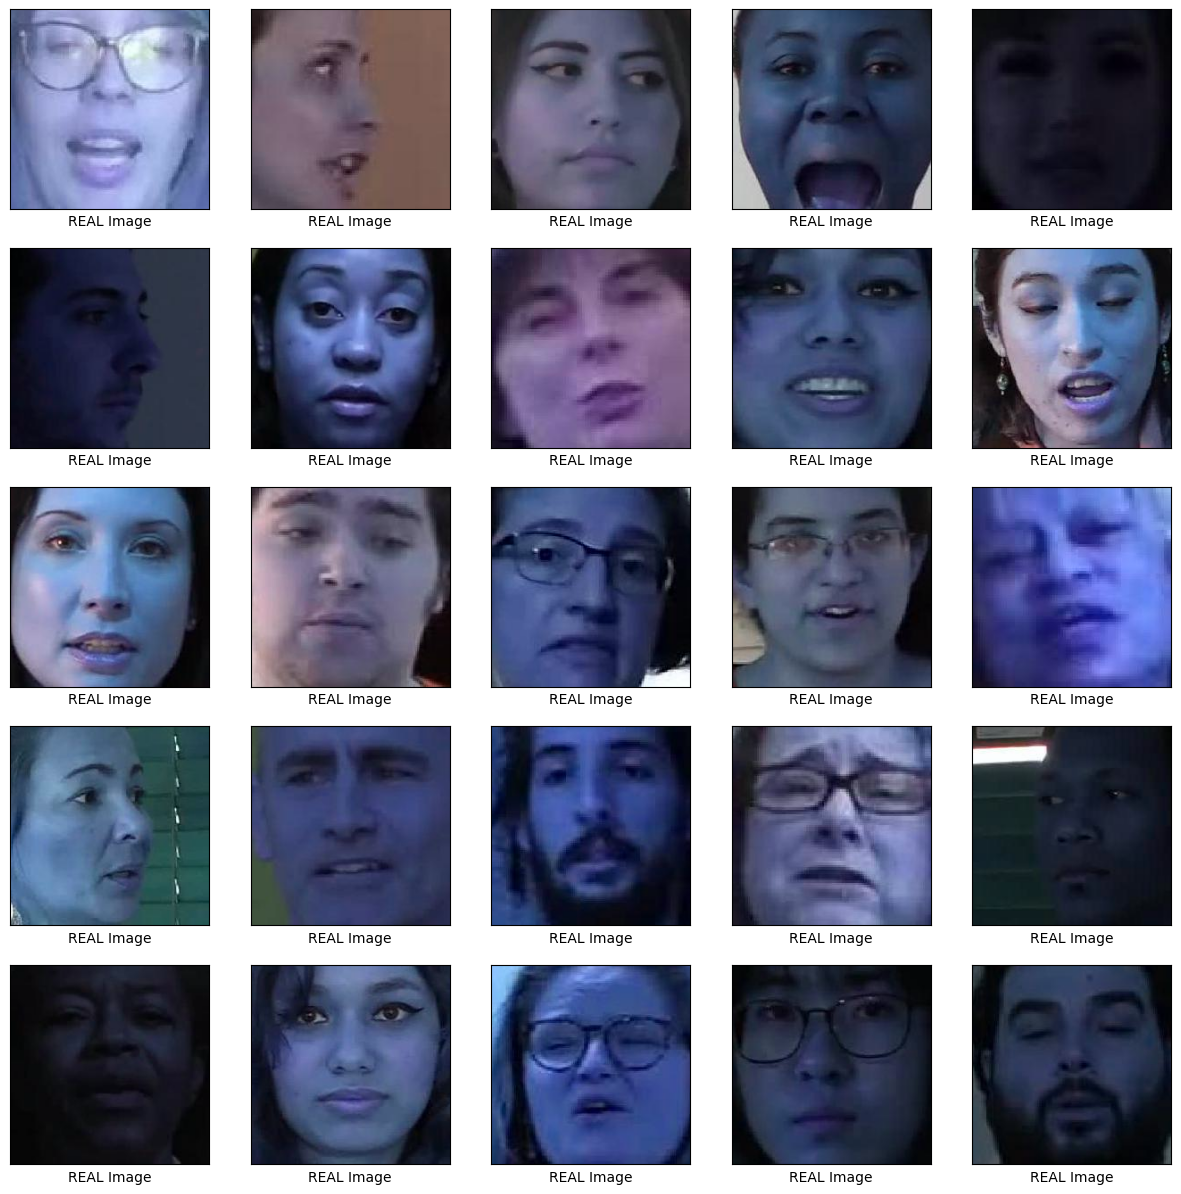

In [7]:
plt.figure(figsize=(15,15))
file_names = os.listdir('/kaggle/working/deepfake-faces/Real/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread('/kaggle/working/deepfake-faces/Real/'+ file_names[idx]))
    # Redundant but i want to test if any fake images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

As we can see from above, we have successfully separated the image files into 2 different subdirectories, `deepfake-faces/Real` and `deepfake-faces/Fake`.

Next, we will organize the data into their appropriate categories before splitting them into training and test/validation data.

This is achieved by splitting the images from `deepfake_and_real_images` into their training/validation/test sets first since those have already been organised for us, then adding on the images from `deepfake_faces`.

In [3]:
train = tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Train', labels = 'inferred', image_size=(224,224),)
val = tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Validation', labels = 'inferred', image_size=(224,224),)
test =  tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Test', labels = 'inferred', image_size=(224,224),)

print(train.class_names)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
['Fake', 'Real']


In [9]:
deepfake_faces = tf.keras.utils.image_dataset_from_directory('/kaggle/working/deepfake-faces', labels='inferred', image_size=(224,224),)

print(deepfake_faces.class_names)



Found 32000 files belonging to 2 classes.
['Fake', 'Real']


In [10]:
deepfake_faces = deepfake_faces.shuffle(10, reshuffle_each_iteration=True)

train_size = int(0.7 * len(deepfake_faces))
test_size = int(0.15 * len(deepfake_faces))
val_size = int(0.15 * len(deepfake_faces))

train2 = deepfake_faces.take(train_size)
test2 = deepfake_faces.skip(train_size)
val2 = test2.skip(val_size)
test2 = test2.take(test_size)

train_merged = train.concatenate(train2)
val_merged = val.concatenate(val2)
test_merged = test.concatenate(test2)

# print(train_merged.class_names)
print(len(train_merged), len(train), len(train2))
print(len(train_merged), len(val_merged), len(test_merged))

5076 4376 700
5076 1383 491


We are now done with merging our datasets, and can move on to training our model.

## Training of Model

### Implementation of Rescaling, Data Augmentation & Callbacks

In [ ]:
#Rescaling and Resizing
rescale_and_resize = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.Rescaling(1./255)
])

In [5]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(0.2),
])

In [6]:
# class CustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy') >= 0.75):
#       print("Accuracy>=75%. Cancelling training.")
# acc_limit_callback = CustomCallback()


checkpoint_filepath = '/kaggle/working/output-models/best.model.keras'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callback_list = [checkpoint_callback]

### Custom functions for testing model

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def produce_cm(model, test_dataset):
    
    true_labels = []
    for images, labels in test_dataset.unbatch().batch(1):
        true_labels.append(labels.numpy())

    test_labels = np.array(true_labels).flatten()

    predictions = model.predict(test_dataset)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_labels  # Assuming you have these


    print(classification_report(true_classes, predicted_classes))
    
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [8]:
def test_accuracy(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    print("Test accuracy:", accuracy)
    

In [9]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
    img = keras.preprocessing.image.load_img(filename, target_size = (224, 224))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    return img

def test_image(model, filename):
    image = load(filename)
    logits = model.predict(image)
    probabilities = np.exp(logits) / np.sum(np.exp(logits))
    print(f'Logits: {logits}')
    print(f'Probabilities: {probabilities}')
    

### Model implementation

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    
    tf.keras.layers.Conv2D(32, kernel_size=5, activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=5,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2), #there are 2 different classes 
])


model.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [ ]:
# history = model.fit(
#     train_merged,
#     validation_data=val_merged,
#     epochs=10,
#     callbacks=callback_list
# )

For our testing, we handpick a few images from either the test dataset or images that have never been introduced before (sourced online).

In [ ]:
#idk why this doesnt work lol might be because loading stuff 

# def test_model(model_input):
#     #Screenshot (12) and (13) are both deepfaked images.
#     files = [
#         '/kaggle/input/testimage/Screenshot (12).png', 
#         '/kaggle/input/testimage2/Screenshot (13).png', 
#     ]
    
#     for i in range(10):
#         num = str(random.randint(1,4000))
#         if i%2:
#             file_name = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_' + num + '.jpg'
#         else: 
#             file_name = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake/fake_' + num + '.jpg'
#         files.append(file_name)
    
    
#     for path in files:
#         image = load('/kaggle/input/testimage/Screenshot (12).png')
#         logits = model_input.predict(image)
#         probabilities = np.exp(logits) / np.sum(np.exp(logits))
#         print(f'{path}: Logits = {logits}, Probabilities = {probabilities}')
        
        

In [ ]:
test_image('/kaggle/input/testimage/Screenshot (12).png')

In [ ]:
test_image('/kaggle/input/testimage2/Screenshot (13).png')

In [ ]:
test_image('/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_412.jpg')

In [ ]:
test_image('/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake/fake_1004.jpg')


In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model_inception = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'), #there are 2 different classes 
])




87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
# model_inception.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy']
#              )


model_inception.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_dataset = train.map(preprocess)
val_dataset = val.map(preprocess)
test_dataset = test.map(preprocess)

In [ ]:
history_real = model_inception.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 470s 105ms/step - accuracy: 0.6603 - loss: 0.7085 - val_accuracy: 0.7023 - val_loss: 0.5613
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 327s 75ms/step - accuracy: 0.7135 - loss: 0.5540 - val_accuracy: 0.6903 - val_loss: 0.5764
Epoch 3/10
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7300 - loss: 0.5307

In [ ]:
test_accuracy(model_inception, test_dataset)

In [ ]:
produce_cm(model_inception, test_dataset)

We observe that the current model is overfitting. Hence we perform hyperparameter tuning.

First we decrease the learning rate of our model.


In [21]:
history_inception = model_inception.fit(
    train_merged,
    validation_data=val_merged,
    epochs=10,
)

Epoch 1/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 566s 109ms/step - accuracy: 0.7653 - loss: 0.7202 - val_accuracy: 0.5013 - val_loss: 0.7052
Epoch 2/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 547s 108ms/step - accuracy: 0.5870 - loss: 0.6241 - val_accuracy: 0.5100 - val_loss: 0.7243
Epoch 3/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 546s 108ms/step - accuracy: 0.8236 - loss: 0.3935 - val_accuracy: 0.5924 - val_loss: 0.6355
Epoch 4/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 547s 108ms/step - accuracy: 0.8316 - loss: 0.3748 - val_accuracy: 0.6372 - val_loss: 0.6111
Epoch 5/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 547s 108ms/step - accuracy: 0.8358 - loss: 0.3681 - val_accuracy: 0.7213 - val_loss: 0.5365
Epoch 6/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 548s 108ms/step - accuracy: 0.8380 - loss: 0.3619 - val_accuracy: 0.6246 - val_loss: 0.6098
Epoch 7/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 547s 108ms/step - accuracy: 0.8420 - loss: 0.3561 - val_accuracy: 0.6530 - val_loss: 0.5897
Epoch 8/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 547s 108ms/step - ac

In [ ]:
loss_inception, accuracy_inception = model_inception.evaluate(test_merged)
print("Test accuracy:", accuracy_inception)

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model2.trainable = False

model_inception2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'), #there are 2 different classes 
])


model_inception2.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
)

In [16]:
history_inception2 = model_inception2.fit(
    train_merged,
    validation_data=val_merged,
    epochs=10,
)

Epoch 1/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 564s 108ms/step - accuracy: 0.7214 - loss: 0.6437 - val_accuracy: 0.5520 - val_loss: 0.6641
Epoch 2/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 576s 113ms/step - accuracy: 0.8187 - loss: 0.4040 - val_accuracy: 0.5574 - val_loss: 0.6618
Epoch 3/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 550s 108ms/step - accuracy: 0.8264 - loss: 0.3837 - val_accuracy: 0.6426 - val_loss: 0.5921
Epoch 4/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 562s 108ms/step - accuracy: 0.8341 - loss: 0.3720 - val_accuracy: 0.5569 - val_loss: 0.6780
Epoch 5/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 551s 109ms/step - accuracy: 0.8363 - loss: 0.3661 - val_accuracy: 0.6130 - val_loss: 0.6282
Epoch 6/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 551s 108ms/step - accuracy: 0.8405 - loss: 0.3604 - val_accuracy: 0.5414 - val_loss: 0.7464
Epoch 7/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 551s 108ms/step - accuracy: 0.8406 - loss: 0.3557 - val_accuracy: 0.6698 - val_loss: 0.5715
Epoch 8/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 550s 108ms/step - ac

In [21]:
loss_inception2, accuracy_inception2 = model_inception2.evaluate(test_merged)
print("Test accuracy:", accuracy_inception2)

491/491 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - accuracy: 0.5616 - loss: 0.7131
Test accuracy: 0.5584208965301514


In [17]:
from tensorflow.keras.applications import ResNet50

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
base_model_resnet.trainable = False

model_resnet = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    base_model_resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


model_resnet.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [19]:
history_resnet = model_resnet.fit(
    train_merged,
    validation_data=val_merged,
    epochs=10,
)

Epoch 1/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 865s 169ms/step - accuracy: 0.6132 - loss: 0.7510 - val_accuracy: 0.5043 - val_loss: 0.6810
Epoch 2/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 854s 168ms/step - accuracy: 0.5802 - loss: 0.6693 - val_accuracy: 0.5005 - val_loss: 0.6931
Epoch 3/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 856s 169ms/step - accuracy: 0.5007 - loss: 0.6934 - val_accuracy: 0.5003 - val_loss: 0.6931
Epoch 4/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 855s 168ms/step - accuracy: 0.5016 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 5/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 855s 168ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 855s 168ms/step - accuracy: 0.5014 - loss: 0.6932 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 7/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 854s 168ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 8/10
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 854s 168ms/step - ac

In [22]:
loss_resnet, accuracy_resnet = model_resnet.evaluate(test_merged)
print("Test accuracy:", accuracy_resnet)

491/491 ━━━━━━━━━━━━━━━━━━━━ 64s 131ms/step - accuracy: 0.4967 - loss: 0.6932
Test accuracy: 0.49812161922454834
